In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot ,starmodels
from astronn import models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd
import shap
from scipy.signal import find_peaks, peak_widths
import pickle

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load data to fine tunning

In [2]:
df_ds = deltascuti()
deltascuti = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

### Read trainned model

In [3]:
# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_dos_200/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 307, 10)           450       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 258, 10)           1210      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 129, 10)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 129, 10)           40        
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 120, 10)           410       
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 116, 10)           310       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 58, 10)            0

In [4]:
# Freeze base model
sepconv_mod.trainable = False

# Check trainable parameters on layers
for layer in sepconv_mod.layers:
    print("%s is trainable=%s" % (layer.name, layer.trainable))

separable_conv1d is trainable=False
separable_conv1d_1 is trainable=False
max_pooling1d is trainable=False
batch_normalization is trainable=False
separable_conv1d_2 is trainable=False
separable_conv1d_3 is trainable=False
max_pooling1d_1 is trainable=False
batch_normalization_1 is trainable=False
dropout is trainable=False
flatten is trainable=False
dense is trainable=False


### Fine tunning

In [5]:
#x = sepconv_mod.output
#x = layers.Dense(100, activation='sigmoid')(x)
#x = layers.Dropout(0.2)(x)

inputs = keras.Input(shape=(406, 2))
x = sepconv_mod(inputs, training=False)
x = keras.layers.Dense(100)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile()

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 406, 2)]          0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               60560     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
Total params: 80,760
Trainable params: 20,200
Non-trainable params: 60,560
_________________________________________________________________


#### Prepare data

In [7]:
stars = [star for star in deltascuti.take(11)]
bedding = [star for star in df_bedding.take(77)]

In [8]:
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

for l in range(200):
    # Iterate over the batches of a dataset.
    #for star in zip(stars, bedding):
    for star in stars:
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            predictions = model(star[1])
            # Compute the loss value for this batch.
            loss_value = loss_fn(tf.reshape(star[2], (1, 100)), predictions)
            print(loss_value)

        # Get gradients of loss wrt the *trainable* weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

tf.Tensor(4.564696, shape=(), dtype=float32)
tf.Tensor(4.619884, shape=(), dtype=float32)
tf.Tensor(4.606429, shape=(), dtype=float32)
tf.Tensor(4.5807137, shape=(), dtype=float32)
tf.Tensor(4.617129, shape=(), dtype=float32)
tf.Tensor(4.5926337, shape=(), dtype=float32)
tf.Tensor(4.63118, shape=(), dtype=float32)
tf.Tensor(4.5799494, shape=(), dtype=float32)
tf.Tensor(4.5906467, shape=(), dtype=float32)
tf.Tensor(4.6104636, shape=(), dtype=float32)
tf.Tensor(4.618891, shape=(), dtype=float32)
tf.Tensor(4.5557466, shape=(), dtype=float32)
tf.Tensor(4.611839, shape=(), dtype=float32)
tf.Tensor(4.6001, shape=(), dtype=float32)
tf.Tensor(4.5741453, shape=(), dtype=float32)
tf.Tensor(4.6106935, shape=(), dtype=float32)
tf.Tensor(4.58606, shape=(), dtype=float32)
tf.Tensor(4.62451, shape=(), dtype=float32)
tf.Tensor(4.5740676, shape=(), dtype=float32)
tf.Tensor(4.5851574, shape=(), dtype=float32)
tf.Tensor(4.603244, shape=(), dtype=float32)
tf.Tensor(4.6128826, shape=(), dtype=float32)
tf.T

tf.Tensor(4.5176044, shape=(), dtype=float32)
tf.Tensor(4.5126963, shape=(), dtype=float32)
tf.Tensor(4.476585, shape=(), dtype=float32)
tf.Tensor(4.514403, shape=(), dtype=float32)
tf.Tensor(4.4826007, shape=(), dtype=float32)
tf.Tensor(4.519732, shape=(), dtype=float32)
tf.Tensor(4.4776983, shape=(), dtype=float32)
tf.Tensor(4.492111, shape=(), dtype=float32)
tf.Tensor(4.482065, shape=(), dtype=float32)
tf.Tensor(4.511334, shape=(), dtype=float32)
tf.Tensor(4.4597025, shape=(), dtype=float32)
tf.Tensor(4.5113726, shape=(), dtype=float32)
tf.Tensor(4.50668, shape=(), dtype=float32)
tf.Tensor(4.4697733, shape=(), dtype=float32)
tf.Tensor(4.507788, shape=(), dtype=float32)
tf.Tensor(4.4756765, shape=(), dtype=float32)
tf.Tensor(4.5127816, shape=(), dtype=float32)
tf.Tensor(4.4712863, shape=(), dtype=float32)
tf.Tensor(4.4858065, shape=(), dtype=float32)
tf.Tensor(4.4740186, shape=(), dtype=float32)
tf.Tensor(4.504608, shape=(), dtype=float32)
tf.Tensor(4.4534297, shape=(), dtype=float32

tf.Tensor(4.3979583, shape=(), dtype=float32)
tf.Tensor(4.3920417, shape=(), dtype=float32)
tf.Tensor(4.3405595, shape=(), dtype=float32)
tf.Tensor(4.3841195, shape=(), dtype=float32)
tf.Tensor(4.3497953, shape=(), dtype=float32)
tf.Tensor(4.387628, shape=(), dtype=float32)
tf.Tensor(4.3553185, shape=(), dtype=float32)
tf.Tensor(4.368696, shape=(), dtype=float32)
tf.Tensor(4.3288336, shape=(), dtype=float32)
tf.Tensor(4.382793, shape=(), dtype=float32)
tf.Tensor(4.336239, shape=(), dtype=float32)
tf.Tensor(4.389723, shape=(), dtype=float32)
tf.Tensor(4.383407, shape=(), dtype=float32)
tf.Tensor(4.3309207, shape=(), dtype=float32)
tf.Tensor(4.374987, shape=(), dtype=float32)
tf.Tensor(4.340708, shape=(), dtype=float32)
tf.Tensor(4.378672, shape=(), dtype=float32)
tf.Tensor(4.3469906, shape=(), dtype=float32)
tf.Tensor(4.3600693, shape=(), dtype=float32)
tf.Tensor(4.3184385, shape=(), dtype=float32)
tf.Tensor(4.374033, shape=(), dtype=float32)
tf.Tensor(4.327602, shape=(), dtype=float32)

tf.Tensor(4.173147, shape=(), dtype=float32)
tf.Tensor(4.2309523, shape=(), dtype=float32)
tf.Tensor(4.2127304, shape=(), dtype=float32)
tf.Tensor(4.1433344, shape=(), dtype=float32)
tf.Tensor(4.198377, shape=(), dtype=float32)
tf.Tensor(4.1678762, shape=(), dtype=float32)
tf.Tensor(4.2098966, shape=(), dtype=float32)
tf.Tensor(4.18915, shape=(), dtype=float32)
tf.Tensor(4.1929708, shape=(), dtype=float32)
tf.Tensor(4.1229496, shape=(), dtype=float32)
tf.Tensor(4.2079973, shape=(), dtype=float32)
tf.Tensor(4.1609845, shape=(), dtype=float32)
tf.Tensor(4.2190695, shape=(), dtype=float32)
tf.Tensor(4.1997604, shape=(), dtype=float32)
tf.Tensor(4.129277, shape=(), dtype=float32)
tf.Tensor(4.1852016, shape=(), dtype=float32)
tf.Tensor(4.155127, shape=(), dtype=float32)
tf.Tensor(4.197535, shape=(), dtype=float32)
tf.Tensor(4.177515, shape=(), dtype=float32)
tf.Tensor(4.1804686, shape=(), dtype=float32)
tf.Tensor(4.1086783, shape=(), dtype=float32)
tf.Tensor(4.195766, shape=(), dtype=float3

tf.Tensor(3.9919088, shape=(), dtype=float32)
tf.Tensor(3.9501452, shape=(), dtype=float32)
tf.Tensor(3.862625, shape=(), dtype=float32)
tf.Tensor(3.9359832, shape=(), dtype=float32)
tf.Tensor(3.915738, shape=(), dtype=float32)
tf.Tensor(3.966335, shape=(), dtype=float32)
tf.Tensor(3.958102, shape=(), dtype=float32)
tf.Tensor(3.9427738, shape=(), dtype=float32)
tf.Tensor(3.8432713, shape=(), dtype=float32)
tf.Tensor(3.9656436, shape=(), dtype=float32)
tf.Tensor(3.9133048, shape=(), dtype=float32)
tf.Tensor(3.9753218, shape=(), dtype=float32)
tf.Tensor(3.931873, shape=(), dtype=float32)
tf.Tensor(3.8433459, shape=(), dtype=float32)
tf.Tensor(3.9179904, shape=(), dtype=float32)
tf.Tensor(3.898542, shape=(), dtype=float32)
tf.Tensor(3.9497545, shape=(), dtype=float32)
tf.Tensor(3.942247, shape=(), dtype=float32)
tf.Tensor(3.9255276, shape=(), dtype=float32)
tf.Tensor(3.8243468, shape=(), dtype=float32)
tf.Tensor(3.9490669, shape=(), dtype=float32)
tf.Tensor(3.8962831, shape=(), dtype=floa

tf.Tensor(3.5115094, shape=(), dtype=float32)
tf.Tensor(3.6725714, shape=(), dtype=float32)
tf.Tensor(3.6118228, shape=(), dtype=float32)
tf.Tensor(3.6747663, shape=(), dtype=float32)
tf.Tensor(3.6016948, shape=(), dtype=float32)
tf.Tensor(3.4990768, shape=(), dtype=float32)
tf.Tensor(3.5966473, shape=(), dtype=float32)
tf.Tensor(3.5921743, shape=(), dtype=float32)
tf.Tensor(3.6539345, shape=(), dtype=float32)
tf.Tensor(3.6570292, shape=(), dtype=float32)
tf.Tensor(3.615852, shape=(), dtype=float32)
tf.Tensor(3.489048, shape=(), dtype=float32)
tf.Tensor(3.6525636, shape=(), dtype=float32)
tf.Tensor(3.5912304, shape=(), dtype=float32)
tf.Tensor(3.6541023, shape=(), dtype=float32)
tf.Tensor(3.5791078, shape=(), dtype=float32)
tf.Tensor(3.4757707, shape=(), dtype=float32)
tf.Tensor(3.5748782, shape=(), dtype=float32)
tf.Tensor(3.5714343, shape=(), dtype=float32)
tf.Tensor(3.6338534, shape=(), dtype=float32)
tf.Tensor(3.6375108, shape=(), dtype=float32)
tf.Tensor(3.594767, shape=(), dtype=

tf.Tensor(3.1184766, shape=(), dtype=float32)
tf.Tensor(3.319963, shape=(), dtype=float32)
tf.Tensor(3.2501323, shape=(), dtype=float32)
tf.Tensor(3.3091586, shape=(), dtype=float32)
tf.Tensor(3.20577, shape=(), dtype=float32)
tf.Tensor(3.094321, shape=(), dtype=float32)
tf.Tensor(3.2181644, shape=(), dtype=float32)
tf.Tensor(3.230573, shape=(), dtype=float32)
tf.Tensor(3.3020349, shape=(), dtype=float32)
tf.Tensor(3.3118467, shape=(), dtype=float32)
tf.Tensor(3.2472641, shape=(), dtype=float32)
tf.Tensor(3.0953276, shape=(), dtype=float32)
tf.Tensor(3.2990403, shape=(), dtype=float32)
tf.Tensor(3.2288063, shape=(), dtype=float32)
tf.Tensor(3.287411, shape=(), dtype=float32)
tf.Tensor(3.1825268, shape=(), dtype=float32)
tf.Tensor(3.0707986, shape=(), dtype=float32)
tf.Tensor(3.1961365, shape=(), dtype=float32)
tf.Tensor(3.2094057, shape=(), dtype=float32)
tf.Tensor(3.281287, shape=(), dtype=float32)
tf.Tensor(3.2912703, shape=(), dtype=float32)
tf.Tensor(3.2256677, shape=(), dtype=floa

tf.Tensor(2.910704, shape=(), dtype=float32)
tf.Tensor(2.9859378, shape=(), dtype=float32)
tf.Tensor(2.995108, shape=(), dtype=float32)
tf.Tensor(2.9219859, shape=(), dtype=float32)
tf.Tensor(2.7459116, shape=(), dtype=float32)
tf.Tensor(2.981259, shape=(), dtype=float32)
tf.Tensor(2.9081721, shape=(), dtype=float32)
tf.Tensor(2.957563, shape=(), dtype=float32)
tf.Tensor(2.83631, shape=(), dtype=float32)
tf.Tensor(2.7237296, shape=(), dtype=float32)
tf.Tensor(2.8703375, shape=(), dtype=float32)
tf.Tensor(2.8925004, shape=(), dtype=float32)
tf.Tensor(2.9677556, shape=(), dtype=float32)
tf.Tensor(2.9766538, shape=(), dtype=float32)
tf.Tensor(2.9036021, shape=(), dtype=float32)
tf.Tensor(2.7259548, shape=(), dtype=float32)
tf.Tensor(2.9629943, shape=(), dtype=float32)
tf.Tensor(2.8899648, shape=(), dtype=float32)
tf.Tensor(2.9386723, shape=(), dtype=float32)
tf.Tensor(2.8169236, shape=(), dtype=float32)
tf.Tensor(2.7044992, shape=(), dtype=float32)
tf.Tensor(2.852214, shape=(), dtype=floa

tf.Tensor(2.6880186, shape=(), dtype=float32)
tf.Tensor(2.5661867, shape=(), dtype=float32)
tf.Tensor(2.4583533, shape=(), dtype=float32)
tf.Tensor(2.618572, shape=(), dtype=float32)
tf.Tensor(2.6370876, shape=(), dtype=float32)
tf.Tensor(2.7099247, shape=(), dtype=float32)
tf.Tensor(2.7116306, shape=(), dtype=float32)
tf.Tensor(2.6490533, shape=(), dtype=float32)
tf.Tensor(2.4456472, shape=(), dtype=float32)
tf.Tensor(2.7048159, shape=(), dtype=float32)
tf.Tensor(2.6355572, shape=(), dtype=float32)
tf.Tensor(2.6735406, shape=(), dtype=float32)
tf.Tensor(2.5521505, shape=(), dtype=float32)
tf.Tensor(2.444744, shape=(), dtype=float32)
tf.Tensor(2.6055098, shape=(), dtype=float32)
tf.Tensor(2.6233387, shape=(), dtype=float32)
tf.Tensor(2.695896, shape=(), dtype=float32)
tf.Tensor(2.6970148, shape=(), dtype=float32)
tf.Tensor(2.6356077, shape=(), dtype=float32)
tf.Tensor(2.4305923, shape=(), dtype=float32)
tf.Tensor(2.6908426, shape=(), dtype=float32)
tf.Tensor(2.6219425, shape=(), dtype=

tf.Tensor(2.5112333, shape=(), dtype=float32)
tf.Tensor(2.502617, shape=(), dtype=float32)
tf.Tensor(2.4638062, shape=(), dtype=float32)
tf.Tensor(2.235636, shape=(), dtype=float32)
tf.Tensor(2.5082874, shape=(), dtype=float32)
tf.Tensor(2.4453309, shape=(), dtype=float32)
tf.Tensor(2.475976, shape=(), dtype=float32)
tf.Tensor(2.3674884, shape=(), dtype=float32)
tf.Tensor(2.2681105, shape=(), dtype=float32)
tf.Tensor(2.432955, shape=(), dtype=float32)
tf.Tensor(2.4332373, shape=(), dtype=float32)
tf.Tensor(2.5004337, shape=(), dtype=float32)
tf.Tensor(2.491135, shape=(), dtype=float32)
tf.Tensor(2.4540925, shape=(), dtype=float32)
tf.Tensor(2.224467, shape=(), dtype=float32)
tf.Tensor(2.4977107, shape=(), dtype=float32)
tf.Tensor(2.4351635, shape=(), dtype=float32)
tf.Tensor(2.4655128, shape=(), dtype=float32)
tf.Tensor(2.3581362, shape=(), dtype=float32)
tf.Tensor(2.259309, shape=(), dtype=float32)
tf.Tensor(2.4241428, shape=(), dtype=float32)
tf.Tensor(2.422961, shape=(), dtype=float

tf.Tensor(2.0692222, shape=(), dtype=float32)
tf.Tensor(2.3485944, shape=(), dtype=float32)
tf.Tensor(2.2925713, shape=(), dtype=float32)
tf.Tensor(2.320632, shape=(), dtype=float32)
tf.Tensor(2.2344868, shape=(), dtype=float32)
tf.Tensor(2.1446462, shape=(), dtype=float32)
tf.Tensor(2.3059998, shape=(), dtype=float32)
tf.Tensor(2.2769501, shape=(), dtype=float32)
tf.Tensor(2.337978, shape=(), dtype=float32)
tf.Tensor(2.317181, shape=(), dtype=float32)
tf.Tensor(2.3130283, shape=(), dtype=float32)
tf.Tensor(2.060741, shape=(), dtype=float32)
tf.Tensor(2.340309, shape=(), dtype=float32)
tf.Tensor(2.2846973, shape=(), dtype=float32)
tf.Tensor(2.3127484, shape=(), dtype=float32)
tf.Tensor(2.2281103, shape=(), dtype=float32)
tf.Tensor(2.138827, shape=(), dtype=float32)
tf.Tensor(2.2997913, shape=(), dtype=float32)
tf.Tensor(2.2687669, shape=(), dtype=float32)
tf.Tensor(2.3294334, shape=(), dtype=float32)
tf.Tensor(2.3079824, shape=(), dtype=float32)
tf.Tensor(2.30588, shape=(), dtype=float

tf.Tensor(2.1797116, shape=(), dtype=float32)
tf.Tensor(2.2091506, shape=(), dtype=float32)
tf.Tensor(1.9387242, shape=(), dtype=float32)
tf.Tensor(2.219022, shape=(), dtype=float32)
tf.Tensor(2.1702797, shape=(), dtype=float32)
tf.Tensor(2.199694, shape=(), dtype=float32)
tf.Tensor(2.1412466, shape=(), dtype=float32)
tf.Tensor(2.0605185, shape=(), dtype=float32)
tf.Tensor(2.213408, shape=(), dtype=float32)
tf.Tensor(2.1481981, shape=(), dtype=float32)
tf.Tensor(2.203072, shape=(), dtype=float32)
tf.Tensor(2.1717002, shape=(), dtype=float32)
tf.Tensor(2.203277, shape=(), dtype=float32)
tf.Tensor(1.9317964, shape=(), dtype=float32)
tf.Tensor(2.212008, shape=(), dtype=float32)
tf.Tensor(2.1637242, shape=(), dtype=float32)
tf.Tensor(2.193297, shape=(), dtype=float32)
tf.Tensor(2.1365957, shape=(), dtype=float32)
tf.Tensor(2.056373, shape=(), dtype=float32)
tf.Tensor(2.2086687, shape=(), dtype=float32)
tf.Tensor(2.141191, shape=(), dtype=float32)
tf.Tensor(2.1956985, shape=(), dtype=float3

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
['HD172189']


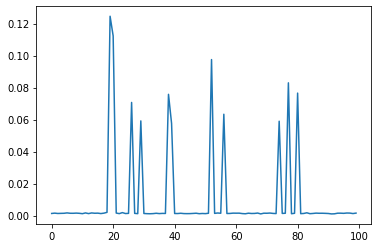

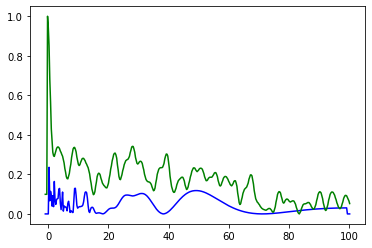

['HD172189', 'CID100866999']


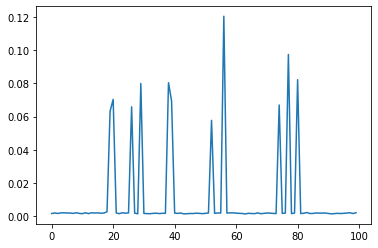

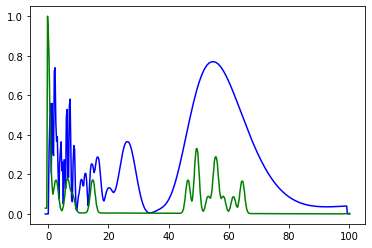

['HD172189', 'CID100866999', 'CID105906206']


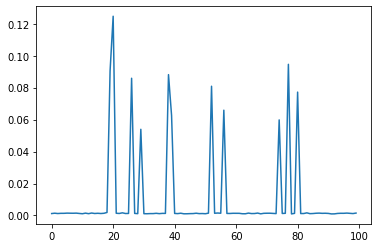

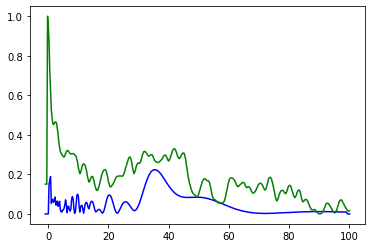

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223']


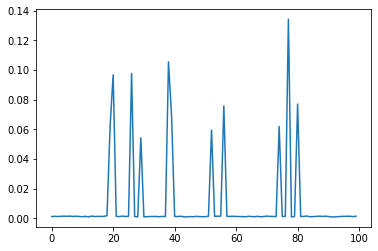

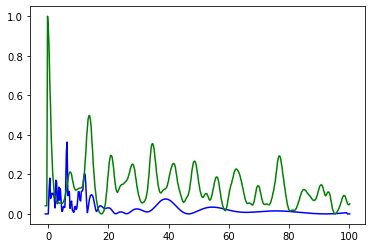

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561']


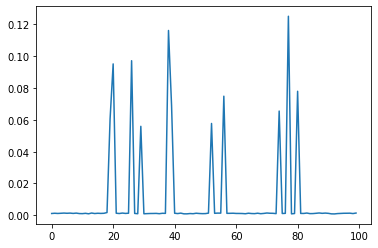

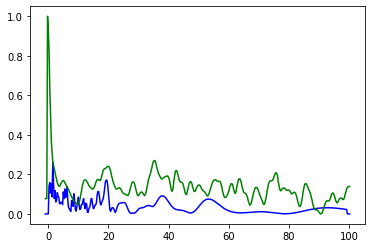

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943']


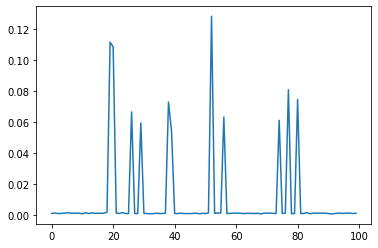

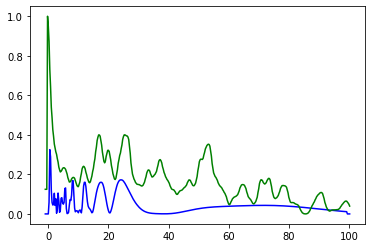

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587']


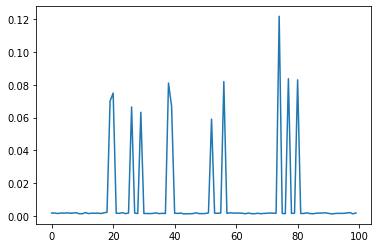

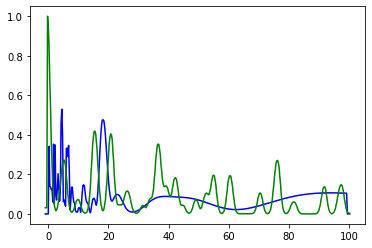

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587', 'KIC3858884']


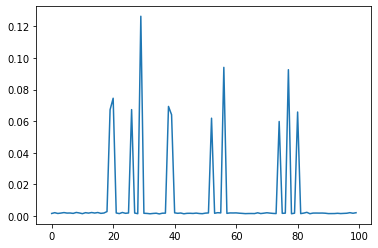

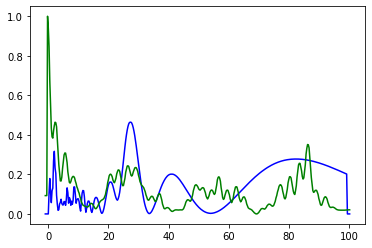

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587', 'KIC3858884', 'KIC9851944']


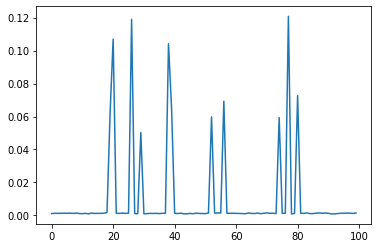

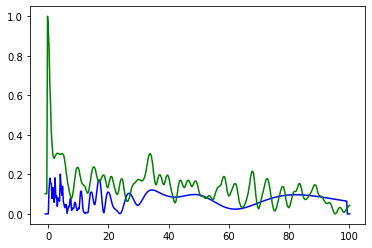

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587', 'KIC3858884', 'KIC9851944', 'HD15082']


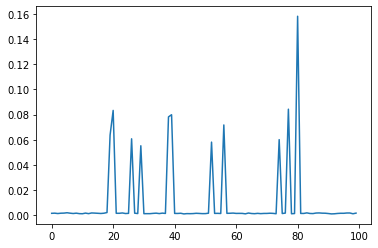

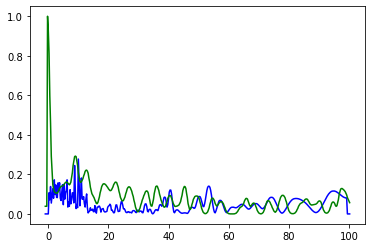

['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587', 'KIC3858884', 'KIC9851944', 'HD15082', 'kic10661783']


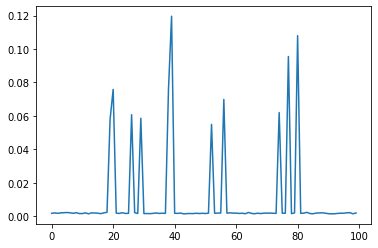

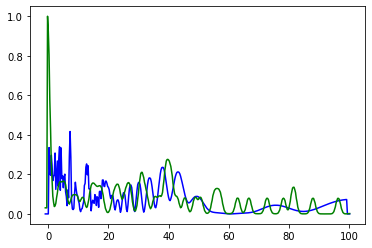

[ 0  0  0  0 39  0  0  0 51  0  0]
8.181818181818182
374.72727272727275
[19, 56, 20, 77, 77, 52, 74, 29, 77, 80, 39]
[19, 56, 20, 77, 38, 52, 74, 29, 26, 80, 39]
['HD172189', 'CID100866999', 'CID105906206', 'KIC8262223', 'HD159561', 'KIC10080943', 'kic4544587', 'KIC3858884', 'KIC9851944', 'HD15082', 'kic10661783']


(0.0, 100.0)

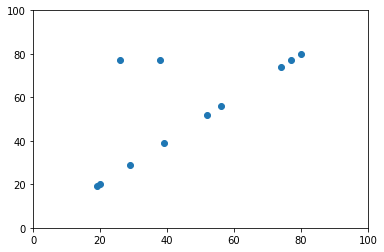

In [9]:
def get_peak_width(position, peaks, peaks_width, peaks_sorted_by_prob):
    """
    """
    peak_id = np.where(probs == peaks_sorted_by_prob[position])[0][0]
    return (peak_id, peaks_width[0][np.where(peaks == peak_id)[0][0]])

x= []
y = []
l = []
for star in stars:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = model.predict(star[1])[0]
    print(l)
    plt.plot(probs)
    plt.show()

    plt.plot( np.arange(-1, 100.5, 0.25), star[1][0, :, 0], label="dft", color="blue")
    #plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
    plt.plot( np.arange(-1, 100.5, 0.25), star[1][0, :, 1], label="ac", color="green")
    plt.show()
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)
    x.append(best_peak)
    y.append(target)

plt.scatter(y, x, label=l)
print(np.asarray(x)-np.asarray(y))
print(np.mean(np.asarray(x)-np.asarray(y)))
print(np.mean(np.power(np.asarray(x)-np.asarray(y), 2)))
print(x)
print(y)
print(l)
plt.xlim(0, 100)
plt.ylim(0, 100)

[  7.55555556 -42.01851852 -13.44444444  -1.01851852  -1.01851852
   4.55555556 -42.01851852  -1.01851852  -1.87037037  -1.01851852
 -30.44444444  -1.01851852 -42.01851852  -7.01851852   7.55555556
  -4.01851852   4.55555556 -30.44444444 -13.44444444 -13.44444444
  -1.01851852   4.55555556  -7.01851852  -4.01851852   7.55555556
 -43.01851852  10.55555556 -13.44444444 -13.44444444   7.55555556
 -13.44444444  19.12962963   7.55555556 -13.44444444  10.55555556
  19.12962963  -4.01851852   4.55555556  19.12962963   7.55555556
 -42.01851852   7.55555556  -1.01851852  -1.01851852   7.55555556
  10.55555556  -1.01851852  -1.01851852   4.55555556 -30.44444444
  -7.01851852  -1.87037037  -4.01851852  19.12962963 -25.01851852
 -30.44444444 -42.01851852  -4.01851852  -1.01851852 -25.01851852
  19.12962963  -7.01851852 -13.44444444 -30.44444444  19.12962963
 -13.44444444   7.55555556   7.55555556 -13.44444444 -13.44444444
 -43.01851852  -1.01851852 -42.01851852  -4.01851852 -42.01851852
  -4.01851

(0.0, 100.0)

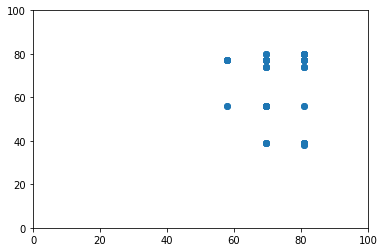

In [10]:


x= []
y = []
l = []
for star in bedding:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = model.predict(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)
    x.append(best_peak)
    y.append(target)

plt.scatter(y, x, label=l)
print(np.asarray(x)-np.asarray(y))
print(np.mean(np.asarray(x)-np.asarray(y)))
print(np.mean(np.power(np.asarray(x)-np.asarray(y), 2)))
print(x)
print(y)
print(l)
plt.xlim(0, 100)
plt.ylim(0, 100)